In [35]:
import pennylane as qml
from pennylane import numpy as pnp
import matplotlib.pyplot as plt

from scipy.optimize import differential_evolution
from scipy.stats.qmc import Halton

import os
import json
import numpy as np
from datetime import datetime, timedelta
import time

from susy_qm import calculate_Hamiltonian

In [36]:
potential = "QHO"
shots = 1024
cutoff = 16

print(f"Running for {potential} potential and cutoff {cutoff}")

starttime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cutoff, potential)
eigenvalues = np.sort(np.linalg.eig(H)[0])[:4]
min_eigenvalue = np.min(eigenvalues).real

num_qubits = int(1 + np.log2(cutoff))

Running for QHO potential and cutoff 16


In [43]:
def cost_function(params, H, num_qubits, shots):
   
    dev = qml.device("default.qubit", wires=num_qubits, shots=shots)
    start = datetime.now()
  
    @qml.qnode(dev)
    def circuit(params):

        qml.RY(params[0], wires=[0])     
        #qml.RY(params[0], wires=[num_qubits-3])
        #qml.RY(params[1], wires=[num_qubits-1])
        #qml.CRY(params[2], wires=[num_qubits-1, num_qubits-2])
        #qml.RY(params[3], wires=[num_qubits-2])
        #qml.RY(params[4], wires=[num_qubits-1])
            
        return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))

    end = datetime.now()
    device_time = (end - start)
    
    return circuit(params), device_time

In [44]:
def run_de_vqe(bounds, max_iter, tol, abs_tol, strategy, popsize, H, num_qubits, shots, num_params):

    generation_best_energies = []
    generation_best_params = []
    generation_population_energies = []
    generation = [0]

    def callback(xk, convergence=None):
        
        best_energy = wrapped_cost_function(xk)
        generation_best_energies.append(best_energy)
        generation_best_params.append(xk.tolist())
        #print('hello', generation)
        generation[0] += 1

    # We need to generate a random seed for each process otherwise each parallelised run will have the same result
    seed = (os.getpid() * int(time.time())) % 123456789
    run_start = datetime.now()

    # Generate Halton sequence
    num_dimensions = num_params
    num_samples = popsize
    halton_sampler = Halton(d=num_dimensions, seed=seed)
    halton_samples = halton_sampler.random(n=num_samples)
    scaled_samples = 2 * np.pi * halton_samples

    device_time = timedelta()

    evaluation_log = []
    evaluation_inputs = []
    def wrapped_cost_function(params):
        result, dt = cost_function(params, H, num_qubits, shots)
        nonlocal device_time
        device_time += dt
        evaluation_log.append((generation[0], result))
        evaluation_inputs.append((generation[0], params))
        return result

    # Differential Evolution optimization
    res = differential_evolution(
        wrapped_cost_function,
        bounds,
        maxiter=max_iter,
        tol=tol,
        atol=abs_tol,
        strategy=strategy,
        popsize=popsize,
        init=scaled_samples,
        seed=seed,
        callback=callback
    )

    run_end = datetime.now()
    run_time = run_end - run_start

    return {
        "seed": seed,
        "energy": res.fun,
        "params": res.x.tolist(),
        "success": res.success,
        "num_iters": res.nit,
        "num_evaluations": res.nfev,
        "run_time": run_time,
        "device_time": device_time,
        "generation_best_energies": generation_best_energies,
        "generation_best_params": generation_best_params,
        "evaluation_log": evaluation_log,
        "evaluation_inputs": evaluation_inputs,
    }

In [45]:
num_params = 1
bounds = [(0, 2*np.pi) for _ in range(num_params)]

num_vqe_runs = 1
max_iter = 200
strategy = "randtobest1bin"
tol = 1e-3
abs_tol = 1e-3
popsize = 20

shots=1024

vqe_starttime = datetime.now()
vqe_data = run_de_vqe(bounds, max_iter, tol, abs_tol, strategy, popsize, H, num_qubits, shots=shots, num_params=num_params)

vqe_end = datetime.now()
vqe_time = vqe_end - vqe_starttime

In [51]:
dev = qml.device("default.qubit", wires=num_qubits, shots=shots)
@qml.qnode(dev)
def circuit(params):

    qml.RY(params[0], wires=[0])     
    #qml.RY(params[0], wires=[num_qubits-3])
    #qml.RY(params[1], wires=[num_qubits-1])
    #qml.CRY(params[2], wires=[num_qubits-1, num_qubits-2])
    #qml.RY(params[3], wires=[num_qubits-2])
    #qml.RY(params[4], wires=[num_qubits-1])
        
    return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))

In [52]:
circuit(vqe_data['params'])

np.float64(0.0)

In [46]:
vqe_data

{'seed': 59199415,
 'energy': np.float64(0.0),
 'params': [3.115591677488885],
 'success': True,
 'num_iters': 7,
 'num_evaluations': 162,
 'run_time': datetime.timedelta(microseconds=134973),
 'device_time': datetime.timedelta(microseconds=7008),
 'generation_best_energies': [np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0),
  np.float64(0.0009765625),
  np.float64(0.0)],
 'generation_best_params': [[3.1307303819145873],
  [3.1307303819145873],
  [3.1307303819145873],
  [3.1307303819145873],
  [3.1307303819145873],
  [3.1632156903850914],
  [3.115591677488885]],
 'evaluation_log': [(0, np.float64(0.013671875)),
  (0, np.float64(0.9873046875)),
  (0, np.float64(0.6025390625)),
  (0, np.float64(0.408203125)),
  (0, np.float64(0.2099609375)),
  (0, np.float64(0.7939453125)),
  (0, np.float64(0.91015625)),
  (0, np.float64(0.09765625)),
  (0, np.float64(0.0947265625)),
  (0, np.float64(0.916015625)),
  (0, np.float64(0.8076171875)),
  (0, np.floa

In [11]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

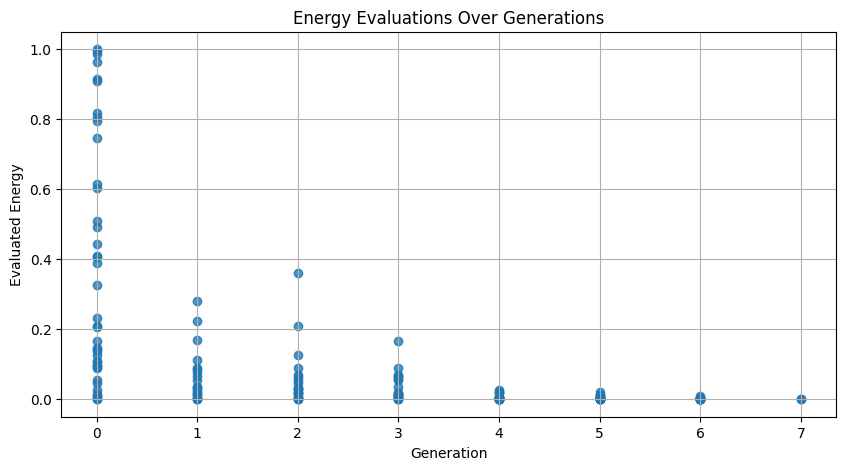

In [47]:
# Unpack for plotting
evaluation_log = vqe_data['evaluation_log']
gens, energies = zip(*evaluation_log)
gens = np.array(gens)
energies = np.array(energies)

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(gens, energies, alpha=0.8)
plt.xlabel("Generation")
plt.ylabel("Evaluated Energy")
plt.title("Energy Evaluations Over Generations")
plt.grid(True)
plt.show()

In [13]:
from collections import defaultdict
from sklearn.preprocessing import StandardScaler

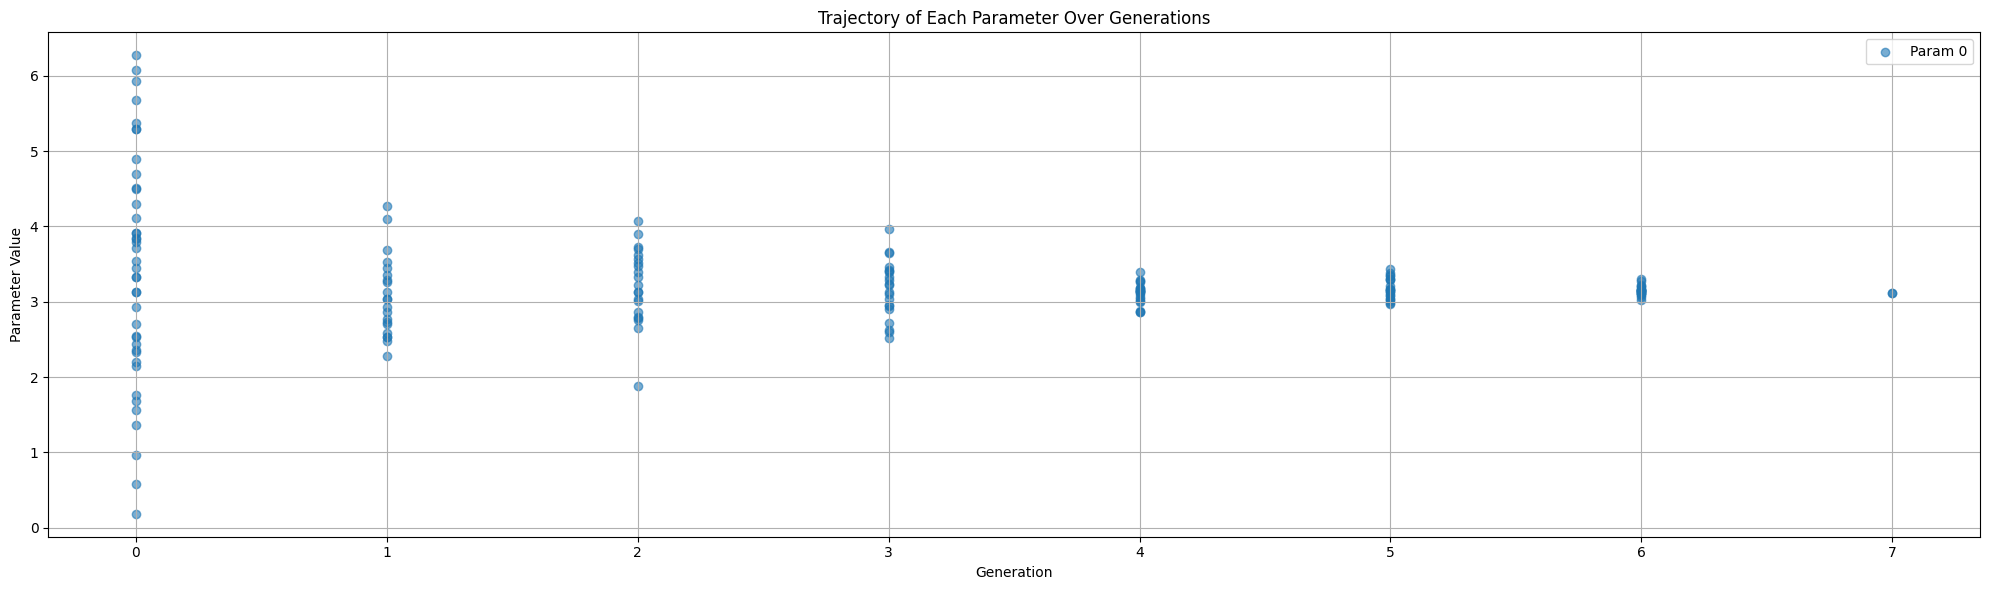

In [49]:
# Organize by generation
gen_to_params = defaultdict(list)
evaluation_inputs = vqe_data['evaluation_inputs']
for gen, param_vec in evaluation_inputs:
    gen_to_params[gen].append(param_vec)

# Transpose per-generation data to param-wise tracking
param_trajectories = defaultdict(list)  # {param_index: [(gen, value), ...]}

for gen in sorted(gen_to_params.keys()):
    for param_vec in gen_to_params[gen]:
        for i, val in enumerate(param_vec):
            param_trajectories[i].append((gen, val))

# Plot
plt.figure(figsize=(20, 6))
for i in range(1):  # 5 parameters
    gens, vals = zip(*param_trajectories[i])
    plt.scatter(gens, vals, label=f"Param {i}", alpha=0.6)

plt.xlabel("Generation")
plt.ylabel("Parameter Value")
plt.title("Trajectory of Each Parameter Over Generations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\Johnk\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Johnk\AppData\Local\Programs\Pyth

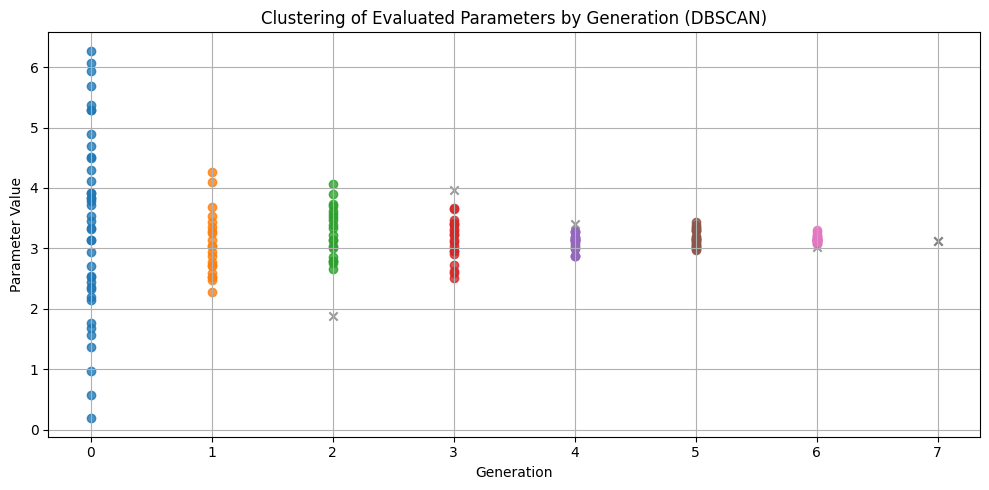

In [53]:
gen_to_params = defaultdict(list)
evaluation_inputs = vqe_data['evaluation_inputs']
for gen, val in evaluation_inputs:
    gen_to_params[gen].append(val)

# Plot clustered points per generation
plt.figure(figsize=(10, 5))

for gen in sorted(gen_to_params.keys()):
    
    params = np.vstack(gen_to_params[gen])
    scaled_params = StandardScaler().fit_transform(params)
    db = DBSCAN(eps=0.5, min_samples=2).fit(scaled_params)
    #params = np.array(gen_to_params[gen]).reshape(-1, 1)
    # DBSCAN — tune `eps` based on your parameter resolution
    #db = DBSCAN(eps=0.01, min_samples=2).fit(params)
    labels = db.labels_
    
    for i, param in enumerate(params):
        label = labels[i]
        if label == -1:
            marker = 'x'
            color = 'gray'
        else:
            marker = 'o'
            color = f"C{gen % 10}"
        
        plt.scatter(gen, param[0], marker=marker, color=color, alpha=0.8)

plt.xlabel("Generation")
plt.ylabel("Parameter Value")
plt.title("Clustering of Evaluated Parameters by Generation (DBSCAN)")
plt.grid(True)
plt.tight_layout()
plt.show()

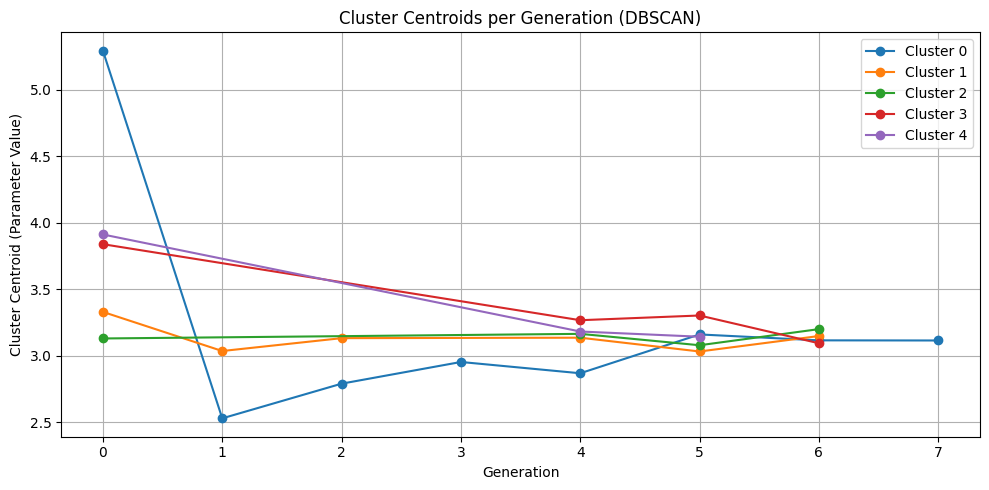

In [54]:
# Group by generation
gen_to_params = defaultdict(list)
for gen, param in evaluation_inputs:
    gen_to_params[gen].append(param)

# Store centroids per generation
centroid_data = []

for gen in sorted(gen_to_params.keys()):
    X = np.array(gen_to_params[gen]).reshape(-1, 1)
    db = DBSCAN(eps=0.01, min_samples=2).fit(X)
    labels = db.labels_

    for label in set(labels):
        if label == -1:
            continue  # skip noise
        cluster_points = X[labels == label].flatten()
        centroid = np.mean(cluster_points)
        centroid_data.append((gen, label, centroid))

# Plot centroids
plt.figure(figsize=(10, 5))

for label in sorted(set(lab for _, lab, _ in centroid_data)):
    xs = [gen for gen, lab, _ in centroid_data if lab == label]
    ys = [centroid for gen, lab, centroid in centroid_data if lab == label]
    plt.plot(xs, ys, marker='o', label=f'Cluster {label}')

plt.xlabel("Generation")
plt.ylabel("Cluster Centroid (Parameter Value)")
plt.title("Cluster Centroids per Generation (DBSCAN)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()